In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy as cp
from sklearn.metrics import accuracy_score
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score

In [2]:
class MLP:

    def __init__(self, X, y, hidden_layer_sizes, activation="sigmoid",
                  learning_rate=0.01, epochs=100, random_state=None,
                  weights=[], bias=[], activation_output="linear", random_w_min = -1, random_w_max = 1,
                  cv_X = None, cv_y = None, print_evey_n_epoch = 100, momentum = 0,
                    epsilon = 1e-8, beta = 0.9, batch_size = None, optimizer = None,
                    beta1_adam =0.9, beta2_adam = 0.999, save_best = False,
                    dropout=[]):
        self.X = pd.DataFrame(X)
        self.y = pd.DataFrame(y)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = cp.deepcopy(activation)
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.weights = cp.deepcopy(weights)
        self.bias = cp.deepcopy(bias)
        self.output_size = None
        self.activation_output = cp.deepcopy(activation_output)
        self.random_w_min = random_w_min
        self.random_w_max = random_w_max
        self.cv_X = cp.deepcopy(cv_X)
        self.cv_y = cp.deepcopy(pd.DataFrame(cv_y))
        self.random_w_bool = False
        self.declared_weights = cp.deepcopy(weights)
        self.declared_bias = cp.deepcopy(bias)
        self.print_evey_n_epoch = cp.deepcopy(print_evey_n_epoch)
        self.batch_size = cp.deepcopy(batch_size)
        self.momentum = cp.deepcopy(momentum)
        self.epsilon = cp.deepcopy(epsilon)
        self.beta = cp.deepcopy(beta)
        self.optimizer = cp.deepcopy(optimizer)
        self.beta1_adam = cp.deepcopy(beta1_adam)
        self.beta2_adam = cp.deepcopy(beta2_adam)
        self.rmsprop_w = None
        self.rmsprop_b = None
        self.adam_m_w = None
        self.adam_m_b = None
        self.adam_v_w = None
        self.adam_v_b = None
        self.t = 0
        self.prev_delta_w = None
        self.prev_delta_b = None
        self.min_cost_function_train = None
        self.min_cost_function_val = None
        self.save_best = cp.deepcopy(save_best)
        self.best_weights = None
        self.best_bias = None
        self.dropout = cp.deepcopy(dropout)
        

    def activation_function(self, x):
        if self.activation == "sigmoid":
            return 1/(1+np.exp(-x))
        if self.activation == "relu":
            return np.maximum(0,x)
        if self.activation == "tanh":
            return np.tanh(x)
        if self.activation == "linear":
            return x
        
    def activation_function_derivative(self, x):
        if self.activation == "sigmoid":
            return (1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x))))
        if self.activation == "relu":
            return np.where(x<=0,0,1)
        if self.activation == "tanh":
            return 1 - np.tanh(x)**2
        if self.activation == "linear":
            return 1
        
    def activation_output_function(self, x):
        if self.activation_output == "sigmoid":
            return 1/(1+np.exp(-x))
        if self.activation_output == "linear":
            return x
        if self.activation_output == "softmax":
            exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    def activation_output_function_derivative(self, x):
        if self.activation_output == "sigmoid":
            return (1/(1+np.exp(-x)))*(1-(1/(1+np.exp(-x))))
        if self.activation_output == "linear":
            return 1
        if self.activation_output == "softmax":
            exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
            softmax_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            return softmax_probs * (1 - softmax_probs)
        
    def loss_function(self, y, ypred):
        if self.activation_output == "sigmoid":
            return -np.sum(y*np.log(ypred))
        if self.activation_output == "linear":
            lf = np.sum(np.square(y - ypred)) / int(y.shape[0])
            lf = lf.round(4)
            return lf.item()
        if self.activation_output == "softmax":
            return np.sum(np.array([-np.sum(y*np.log(ypred))])).round(4)
        
    def loss_function_derivative(self, y, ypred):
        if self.activation_output == "sigmoid":
            return y-ypred
        if self.activation_output == "linear":
            return 2*(y-ypred)
        if self.activation_output == "softmax":
            return y-ypred
        
    def loss_function_print(self, y, ypred):
        if self.activation_output == "linear":
            return str(np.array([np.sum(np.square(y - ypred)) / y.shape[0]]))[2:-2]
        if self.activation_output == "sigmoid":
            return str(np.array([-np.sum(y*np.log(ypred))]))[2:-2]
        if self.activation_output == "softmax":
            return np.sum(np.array([-np.sum(y*np.log(ypred))])).round(4)
        
    def OneHot(self, y):
        n = y.iloc[:,0].max() + 1
        return np.eye(n)[y]

    def feedforward(self, X, predict=False):
        z = []
        a = []
        for i in range(len(self.weights)):
            if i == 0:
                z.append(np.dot(X, self.weights[i]) + self.bias[i])
                a.append(self.activation_function(z[i]))
            elif i == len(self.weights)-1:
                z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
                a.append(self.activation_output_function(z[i]))
            else:
                z.append(np.dot(a[i-1], self.weights[i]) + self.bias[i])
                a.append(self.activation_function(z[i]))
        if len(self.dropout) != 0 and predict == False:
            dropout_count = []
            for i in range(len(a)-1):
                temp_count = len(a[i].flatten())
                dropout_count.append(temp_count)

            dropout_factor = [np.ones_like(x).flatten() for x in a[:-1]]
            for layer in range(len(a)-1):
                limit = int(self.dropout[layer] * dropout_count[layer])
                count = 0
                for neuron in range(len(a[layer].flatten())):
                        if count == limit:
                            break
                        else:
                            dropout_factor[layer][neuron] = 0
                            count += 1
                np.random.shuffle(dropout_factor[layer])
                dropout_factor[layer] = dropout_factor[layer].reshape(a[layer].shape)
                a[layer] = a[layer] * dropout_factor[layer]
        return z, a
    
    def backpropagation(self, z, a, y, x):
        delta_w = [0] * len(self.weights)
        delta_w_final = [0] * len(self.weights)
        delta_b = [0] * len(self.bias)
        for i in range(len(self.weights) - 1, -1, -1):
            if i == (len(self.weights) - 1):
                delta_w[i] = self.loss_function_derivative(y, a[i]) * self.activation_output_function_derivative(z[i])
                delta_w_final[i] = np.dot(a[i - 1].T, delta_w[i])
                delta_b[i] = self.loss_function_derivative(y, a[i]) * self.activation_output_function_derivative(z[i])
            elif i == 0:
                delta_w[i] = np.dot(delta_w[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
                delta_w_final[i] = np.dot(x.T, delta_w[i])
                delta_b[i] = np.dot(delta_b[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
            else:
                delta_w[i] = np.dot(delta_w[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
                delta_w_final[i] = np.dot(a[i - 1].T, delta_w[i])
                delta_b[i] = np.dot(delta_b[i + 1], self.weights[i + 1].T) * self.activation_function_derivative(z[i])
        return delta_w_final, delta_b        

    def fit(self):
        if self.activation_output == "softmax":
            self.output_size = cp.deepcopy(len(np.unique(self.y)))
            self.y = cp.deepcopy(pd.DataFrame(self.OneHot(self.y).reshape(self.y.shape[0], self.output_size)))
            if self.cv_X is not None:
                self.cv_y = cp.deepcopy(pd.DataFrame(self.OneHot(self.cv_y).reshape(self.cv_y.shape[0], self.output_size)))
        else:
            self.output_size = 1
        if len(self.weights) == 0 or len(self.bias) == 0:
            if self.random_state != None:
                np.random.seed(self.random_state)
            else:
                self.random_state = int(np.random.randint(0, 10000000, size=(1, 1)))
                np.random.seed(self.random_state)
            self.random_w_bool = True
            self.weights = [0] * (len(self.hidden_layer_sizes) + 1)
            self.bias = [0] * (len(self.hidden_layer_sizes) + 1)
            for i in range(len(self.hidden_layer_sizes) + 1):
                if i == 0:
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.X.shape[1],self.hidden_layer_sizes[i])).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
                elif i == len(self.hidden_layer_sizes):
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.output_size)).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.output_size)).astype(np.float64)
                else:
                    self.weights[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.hidden_layer_sizes[i])).astype(np.float64)
                    self.bias[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
        elif len(self.weights) != len(self.bias):
            raise ValueError("Number of weights and bias must be equal")
        else:
            pass
        self.prev_delta_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.prev_delta_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.rmsprop_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.rmsprop_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.adam_m_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.adam_m_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.adam_v_w = cp.deepcopy([np.zeros_like(w) for w in self.weights])
        self.adam_v_b = cp.deepcopy([np.zeros_like(b) for b in self.bias])
        self.t = 0
        if self.batch_size != None:
            number_of_batches = int(self.X.shape[0] / self.batch_size)
            if self.X.shape[0] % self.batch_size != 0:
                number_of_batches += 1
        else:
            self.batch_size = cp.deepcopy(self.X.shape[0])
            number_of_batches = 1
        for i in range(self.epochs):
            if i == 0:
                self.X = self.X.sample(frac=1, random_state=self.random_state)
                self.y = self.y.sample(frac=1, random_state=self.random_state)
            else:
                self.X = self.X.sample(frac=1, random_state=(self.random_state + i))
                self.y = self.y.sample(frac=1, random_state=(self.random_state + i))
            for n in range(0, number_of_batches):
                delta_w = [np.zeros_like(w) for w in self.weights]
                delta_b = [np.zeros_like(b) for b in self.bias]
                if (n == number_of_batches-1) and (self.X.shape[0] % self.batch_size != 0):
                    for b in range(0, self.X.shape[0] % self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= (self.X.shape[0] % self.batch_size)
                        delta_b[l] /= (self.X.shape[0] % self.batch_size)
                else:
                    for b in range(0, self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= self.batch_size
                        delta_b[l] /= self.batch_size
                for k in range(len(self.weights)):
                    if self.optimizer is None:
                        self.weights[k] += self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k]
                        self.bias[k] += self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k]
                        self.prev_delta_w[k] = cp.deepcopy(self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k])
                        self.prev_delta_b[k] = cp.deepcopy(self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k])
                    elif self.optimizer == "rmsprop":
                        self.rmsprop_w[k] = self.beta * self.rmsprop_w[k] + (1 - self.beta) * delta_w[k] ** 2
                        self.rmsprop_b[k] = self.beta * self.rmsprop_b[k] + (1 - self.beta) * delta_b[k] ** 2
                        self.weights[k] += self.learning_rate * delta_w[k] / (np.sqrt(self.rmsprop_w[k]) + self.epsilon)
                        self.bias[k] += self.learning_rate * delta_b[k] / (np.sqrt(self.rmsprop_b[k]) + self.epsilon)
                    elif self.optimizer == "adam":
                        self.t += 1
                        self.adam_m_w[k] = self.beta1_adam * self.adam_m_w[k] + (1 - self.beta1_adam) * delta_w[k]
                        self.adam_m_b[k] = self.beta1_adam * self.adam_m_b[k] + (1 - self.beta1_adam) * delta_b[k]
                        self.adam_v_w[k] = self.beta2_adam * self.adam_v_w[k] + (1 - self.beta2_adam) * delta_w[k] ** 2
                        self.adam_v_b[k] = self.beta2_adam * self.adam_v_b[k] + (1 - self.beta2_adam) * delta_b[k] ** 2
                        adam_m_w_hat = self.adam_m_w[k] / (1 - self.beta1_adam ** self.t)
                        adam_m_b_hat = self.adam_m_b[k] / (1 - self.beta1_adam ** self.t)
                        adam_v_w_hat = self.adam_v_w[k] / (1 - self.beta2_adam ** self.t)
                        adam_v_b_hat = self.adam_v_b[k] / (1 - self.beta2_adam ** self.t)
                        self.weights[k] += self.learning_rate * adam_m_w_hat / (np.sqrt(adam_v_w_hat) + self.epsilon)
                        self.bias[k] += self.learning_rate * adam_m_b_hat / (np.sqrt(adam_v_b_hat) + self.epsilon)
            preds_train = self.predict(self.X)
            if self.activation_output == "sigmoid":
                loss_train = float(self.loss_function(self.y, preds_train).values[0])
            else:
                loss_train = self.loss_function(self.y, preds_train)
            if self.cv_X is not None:
                preds_val = self.predict(self.cv_X)
                loss_val = self.loss_function(self.cv_y, preds_val)
            if self.min_cost_function_train is None or self.min_cost_function_train > loss_train:
                self.min_cost_function_train = loss_train
                if self.save_best is True:
                    self.best_weights = cp.deepcopy(self.weights)
                    self.best_bias = cp.deepcopy(self.bias)
            if self.cv_X is not None and (self.min_cost_function_val is None or self.min_cost_function_val > loss_val):
                self.min_cost_function_val = loss_val
            if (i+1) % self.print_evey_n_epoch == 0 or i == 0:
                if self.cv_X is None:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        preds_train.columns = ["class"]
                        preds_train["class"] = preds_train["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        f1_train = f1_score(self.y, preds_train["class"], average="binary").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} F1: {f1_train:^7} ===")
                else:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} === Val MSE: {loss_val:^14} === Min: {self.min_cost_function_val:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        preds_val = pd.DataFrame(preds_val).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        f1_val = f1_score(pd.DataFrame(self.cv_y).idxmax(axis=1), preds_val, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        preds_val = pd.DataFrame(preds_val)
                        preds_train.columns = ["class"]
                        preds_val.columns = ["class"]
                        preds_train["class"] = preds_train["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        preds_val["class"] = preds_val["class"].apply(lambda x: 1 if x > 0.5 else 0)
                        f1_train = f1_score(self.y, preds_train["class"], average="binary").round(4)
                        f1_val = f1_score(self.cv_y, preds_val["class"], average="binary").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                
    
    def continue_fit(self, epochs):
        if self.batch_size != None:
            number_of_batches = int(self.X.shape[0] / self.batch_size)
            if self.X.shape[0] % self.batch_size != 0:
                number_of_batches += 1
        else:
            self.batch_size = cp.deepcopy(self.X.shape[0])
            number_of_batches = 1
        for i in range(epochs):
            if i == 0:
                self.X = self.X.sample(frac=1, random_state=self.random_state)
                self.y = self.y.sample(frac=1, random_state=self.random_state)
            else:
                self.X = self.X.sample(frac=1, random_state=(self.random_state + i))
                self.y = self.y.sample(frac=1, random_state=(self.random_state + i))
            for n in range(0, number_of_batches):
                delta_w = [np.zeros_like(w) for w in self.weights]
                delta_b = [np.zeros_like(b) for b in self.bias]
                if (n == number_of_batches-1) and (self.X.shape[0] % self.batch_size != 0):
                    for b in range(0, self.X.shape[0] % self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= (self.X.shape[0] % self.batch_size)
                        delta_b[l] /= (self.X.shape[0] % self.batch_size)
                else:
                    for b in range(0, self.batch_size):
                        z, a = self.feedforward(np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        delta_w_temp, delta_b_temp = self.backpropagation(z, a, np.array([self.y.iloc[n * self.batch_size + b, :].values]), np.array([self.X.iloc[n * self.batch_size + b, :].values]))
                        for r in range(len(delta_w)):
                            delta_w[r] = delta_w[r] + delta_w_temp[r]
                            delta_b[r] = delta_b[r] + delta_b_temp[r]
                    for l in range(len(delta_w)):
                        delta_w[l] /= self.batch_size
                        delta_b[l] /= self.batch_size
                for k in range(len(self.weights)):
                    if self.optimizer is None:
                        self.weights[k] += self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k]
                        self.bias[k] += self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k]
                        self.prev_delta_w[k] = cp.deepcopy(self.learning_rate * delta_w[k] + self.momentum * self.prev_delta_w[k])
                        self.prev_delta_b[k] = cp.deepcopy(self.learning_rate * delta_b[k] + self.momentum * self.prev_delta_b[k])
                    elif self.optimizer == "rmsprop":
                        self.rmsprop_w[k] = self.beta * self.rmsprop_w[k] + (1 - self.beta) * delta_w[k] ** 2
                        self.rmsprop_b[k] = self.beta * self.rmsprop_b[k] + (1 - self.beta) * delta_b[k] ** 2
                        self.weights[k] += self.learning_rate * delta_w[k] / (np.sqrt(self.rmsprop_w[k]) + self.epsilon)
                        self.bias[k] += self.learning_rate * delta_b[k] / (np.sqrt(self.rmsprop_b[k]) + self.epsilon)
                    elif self.optimizer == "adam":
                        self.t += 1
                        self.adam_m_w[k] = self.beta1_adam * self.adam_m_w[k] + (1 - self.beta1_adam) * delta_w[k]
                        self.adam_m_b[k] = self.beta1_adam * self.adam_m_b[k] + (1 - self.beta1_adam) * delta_b[k]
                        self.adam_v_w[k] = self.beta2_adam * self.adam_v_w[k] + (1 - self.beta2_adam) * delta_w[k] ** 2
                        self.adam_v_b[k] = self.beta2_adam * self.adam_v_b[k] + (1 - self.beta2_adam) * delta_b[k] ** 2
                        adam_m_w_hat = self.adam_m_w[k] / (1 - self.beta1_adam ** self.t)
                        adam_m_b_hat = self.adam_m_b[k] / (1 - self.beta1_adam ** self.t)
                        adam_v_w_hat = self.adam_v_w[k] / (1 - self.beta2_adam ** self.t)
                        adam_v_b_hat = self.adam_v_b[k] / (1 - self.beta2_adam ** self.t)
                        self.weights[k] += self.learning_rate * adam_m_w_hat / (np.sqrt(adam_v_w_hat) + self.epsilon)
                        self.bias[k] += self.learning_rate * adam_m_b_hat / (np.sqrt(adam_v_b_hat) + self.epsilon)
            preds_train = self.predict(self.X)
            if self.activation_output == "sigmoid":
                loss_train = float(self.loss_function(self.y, preds_train).values[0])
            else:
                loss_train = self.loss_function(self.y, preds_train)
            if self.cv_X is not None:
                preds_val = self.predict(self.cv_X)
                loss_val = self.loss_function(self.cv_y, preds_val)
            if self.min_cost_function_train is None or self.min_cost_function_train > loss_train:
                if self.save_best is True:
                    self.best_weights = cp.deepcopy(self.weights)
                    self.best_bias = cp.deepcopy(self.bias)
                self.min_cost_function_train = loss_train
            if self.cv_X is not None and (self.min_cost_function_val is None or self.min_cost_function_val > loss_val):
                self.min_cost_function_val = loss_val
            if (i+1) % self.print_evey_n_epoch == 0 or i == 0:
                if self.cv_X is None:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} ===")
                else:
                    if self.activation_output == "linear":
                        print(f"=== Epoch: {i + 1:^7} === Train MSE: {loss_train:^14} === Min: {self.min_cost_function_train:^14} === Val MSE: {loss_val:^14} === Min: {self.min_cost_function_val:^14} ===")
                    elif self.activation_output == "softmax":
                        preds_train = pd.DataFrame(preds_train).idxmax(axis=1)
                        preds_val = pd.DataFrame(preds_val).idxmax(axis=1)
                        f1_train = f1_score(pd.DataFrame(self.y).idxmax(axis=1), preds_train, average="macro").round(4)
                        f1_val = f1_score(pd.DataFrame(self.cv_y).idxmax(axis=1), preds_val, average="macro").round(4)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14} Min: {self.min_cost_function_train:^14} F1: {f1_train:^7} === Val CrossEntropy: {loss_val:^14} Min: {self.min_cost_function_val:^14} F1: {f1_val:^7} ===")
                    elif self.activation_output == "sigmoid":
                        preds_train = pd.DataFrame(preds_train)
                        print(f"=== Epoch: {i + 1:^7} === Train CrossEntropy: {loss_train:^14.4f} Min: {self.min_cost_function_train:^14.4f} ===")

    def predict(self, X):
        z, a = self.feedforward(X, predict=True)
        return a[-1]
    
    def predict_best(self, X):
        z = []
        a = []
        for i in range(len(self.best_weights)):
            if i == 0:
                z.append(np.dot(X, self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_function(z[i]))
            elif i == len(self.best_weights)-1:
                z.append(np.dot(a[i-1], self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_output_function(z[i]))
            else:
                z.append(np.dot(a[i-1], self.best_weights[i]) + self.best_bias[i])
                a.append(self.activation_function(z[i]))
        return a[-1]
    
    def initial_weights(self):
        if self.random_w_bool == True:
            np.random.seed(self.random_state)
            wts = [0] * (len(self.hidden_layer_sizes) + 1)
            bs = [0] * (len(self.hidden_layer_sizes) + 1)
            for i in range(len(self.hidden_layer_sizes) + 1):
                if i == 0:
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.X.shape[1],self.hidden_layer_sizes[i])).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
                elif i == len(self.hidden_layer_sizes):
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.output_size)).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.output_size)).astype(np.float64)
                else:
                    wts[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(self.hidden_layer_sizes[i - 1], self.hidden_layer_sizes[i])).astype(np.float64)
                    bs[i] = np.random.uniform(low=self.random_w_min, high=self.random_w_max, size=(1, self.hidden_layer_sizes[i])).astype(np.float64)
            return [wts, bs]
        else:
            return [[self.declared_weights],[self.declared_bias]]

    
    def get_params(self, deep=True):
        return {"hidden_layer_sizes": self.hidden_layer_sizes,
                "output_size": self.output_size,
                "optimizer": self.optimizer,
                 "activation": self.activation,
                   "activation_output": self.activation_output,
                     "epochs": self.epochs,
                     "batch_size": self.batch_size,
                       "learning_rate": self.learning_rate,
                         "random_state": self.random_state,
                           "random_w_min": self.random_w_min,
                             "random_w_max": self.random_w_max,
                             "initial_weights": self.initial_weights()[0],
                             "initial_bias": self.initial_weights()[1]}
    

    

    


In [33]:
train = pd.read_csv('/Users/adekkiezun/Downloads/mio1/classification/rings5-regular-training.csv')
test = pd.read_csv('/Users/adekkiezun/Downloads/mio1/classification/rings5-regular-test.csv')
X_train = pd.DataFrame(train[["x", "y"]])
y_train = pd.DataFrame(train["c"])
X_test = pd.DataFrame(test[["x", "y"]])
y_test = pd.DataFrame(test["c"])
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [35]:
train

,x,y,c
0,26.926121,-16.588451,0
1,-77.438767,95.159464,0
2,-98.650099,94.923714,0
3,22.241184,-5.447678,0
4,12.843637,-21.496457,0
...,...,...,...
1245,-84.434019,28.806532,4
1246,-85.961328,11.903486,4
1247,-11.179137,84.956382,4
1248,-70.669378,91.289901,4


In [39]:
classifier = MLP(X=X_train, y=y_train, hidden_layer_sizes=[10, 10], activation="tanh",
                  activation_output="softmax", learning_rate=0.0005, epochs=1000, random_w_min = -5, random_w_max = 5,
                  print_evey_n_epoch=10, optimizer="adam", beta1_adam=0.9, beta2_adam=0.999, epsilon=1e-8,
                  cv_X=X_test, cv_y=y_test, batch_size=64)
classifier.fit()  #1000   === Train CrossEntropy:    932.4056

=== Epoch:    1    === Train CrossEntropy:   12903.3025   Min:   12903.3025   F1: 0.2292  === Val CrossEntropy:   23779.818    Min:   23779.818    F1:  0.164  ===
=== Epoch:   10    === Train CrossEntropy:   11282.1709   Min:   11282.1709   F1: 0.2864  === Val CrossEntropy:   22431.7247   Min:   22431.7247   F1:  0.216  ===
=== Epoch:   20    === Train CrossEntropy:   10415.9614   Min:   10415.9614   F1: 0.3493  === Val CrossEntropy:   21585.7397   Min:   21585.7397   F1: 0.2434  ===
=== Epoch:   30    === Train CrossEntropy:    9875.98     Min:    9875.98     F1: 0.3857  === Val CrossEntropy:   20803.8793   Min:   20803.8793   F1: 0.2596  ===
=== Epoch:   40    === Train CrossEntropy:   9446.5339    Min:   9446.5339    F1: 0.4068  === Val CrossEntropy:   19937.1048   Min:   19937.1048   F1: 0.2715  ===
=== Epoch:   50    === Train CrossEntropy:   9000.4933    Min:   9000.4933    F1: 0.4192  === Val CrossEntropy:   19041.3364   Min:   19041.3364   F1: 0.2781  ===
=== Epoch:   60    ===

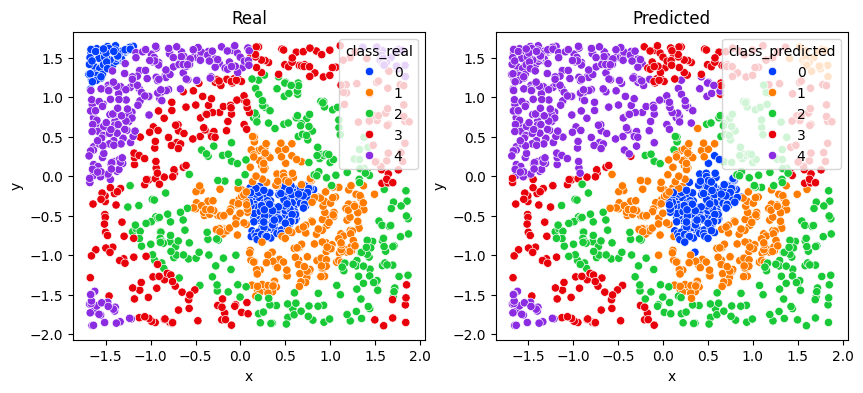

In [40]:
preds = classifier.predict(X_train)
preds = pd.DataFrame(preds)
preds = preds.idxmax(axis=1)
preds = pd.DataFrame(preds)
preds.columns = ["class_predicted"]
wynik = X_train.copy()
wynik["class_real"] = y_train.copy()
wynik["class_predicted"] = preds.copy()
def equal(x):
    if x["class_real"] == x["class_predicted"]:
        return 1
    else:
        return 0
wynik["equal"] = wynik.apply(equal, axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x="x", y="y", hue="class_real", data=wynik, palette="bright")
plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
sns.scatterplot(x="x", y="y", hue="class_predicted", data=wynik, palette="bright")
plt.subplots_adjust(wspace=0.2)
plt.subplot(1, 2, 1).title.set_text(f'Real')
plt.subplot(1, 2, 2).title.set_text(f'Predicted')
plt.show()

In [43]:
# compute f measure
from sklearn.metrics import f1_score
preds = classifier.predict(X_test)
preds = pd.DataFrame(preds)
preds = preds.idxmax(axis=1)

f1_score(y_test, preds, average='macro').round(3) # 0.9993333333333333

0.49

In [42]:
# compute accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds).round(3) # 0.9993333333333333

0.626

In [6]:
train = pd.read_csv('/Users/adekkiezun/Downloads/mio1/regression/square-simple-training.csv')
test = pd.read_csv('/Users/adekkiezun/Downloads/mio1/regression/square-simple-test.csv')
X_train = pd.DataFrame(train["x"])
y_train = pd.DataFrame(train["y"])
X_test = pd.DataFrame(test["x"])
y_test = pd.DataFrame(test["y"])

In [29]:
regressor = MLP(X=X_train, y=y_train, hidden_layer_sizes=[10], activation="tanh",
                  activation_output="linear", learning_rate=0.05, epochs=10000, random_w_min = -5, random_w_max = 5,
                  print_evey_n_epoch=10, optimizer="adam", beta1_adam=0.9, beta2_adam=0.999, epsilon=1e-8,
                  cv_X=X_test, cv_y=y_test, batch_size=16)
regressor.fit()  

=== Epoch:    1    === Train MSE:   10765.9526   === Min:   10765.9526   === Val MSE:   9443.7213    === Min:   9443.7213    ===
=== Epoch:   10    === Train MSE:   6484.2296    === Min:   6484.2296    === Val MSE:   5108.7543    === Min:   5108.7543    ===
=== Epoch:   20    === Train MSE:   4042.4824    === Min:   4042.4824    === Val MSE:   2852.5636    === Min:   2852.5636    ===
=== Epoch:   30    === Train MSE:   3101.8536    === Min:   3101.8536    === Val MSE:   2040.3762    === Min:   2040.3762    ===
=== Epoch:   40    === Train MSE:    2617.328    === Min:    2617.328    === Val MSE:   1643.5648    === Min:   1643.5648    ===
=== Epoch:   50    === Train MSE:   2260.0309    === Min:   2260.0309    === Val MSE:   1374.5121    === Min:   1374.5121    ===
=== Epoch:   60    === Train MSE:   1988.4032    === Min:   1988.4032    === Val MSE:   1166.9907    === Min:   1166.9907    ===
=== Epoch:   70    === Train MSE:   1757.1234    === Min:   1757.1234    === Val MSE:   1003.3558

In [30]:
preds = regressor.predict(X_train)
preds = pd.DataFrame(preds)
preds.columns = ["y_pred"]
wykres = pd.DataFrame(y_train["y"])
wykres["real"] = 1
wykres["x"] = X_train["x"]
wykres_temp = pd.DataFrame(preds["y_pred"]).rename(columns={"y_pred": "y"})
wykres_temp["real"] = 0
wykres_temp["x"] = X_train["x"]
wykres = pd.concat([wykres, wykres_temp], ignore_index=True)


preds_test = regressor.predict(X_test)
preds_test = pd.DataFrame(preds_test)
preds_test.columns = ["y_pred"]
wykres_test = pd.DataFrame(y_test["y"])
wykres_test["real"] = 1
wykres_test["x"] = X_test["x"]
wykres_temp_test = pd.DataFrame(preds_test["y_pred"]).rename(columns={"y_pred": "y"})
wykres_temp_test["real"] = 0
wykres_temp_test["x"] = X_test["x"]
wykres_test = pd.concat([wykres_test, wykres_temp_test], ignore_index=True)


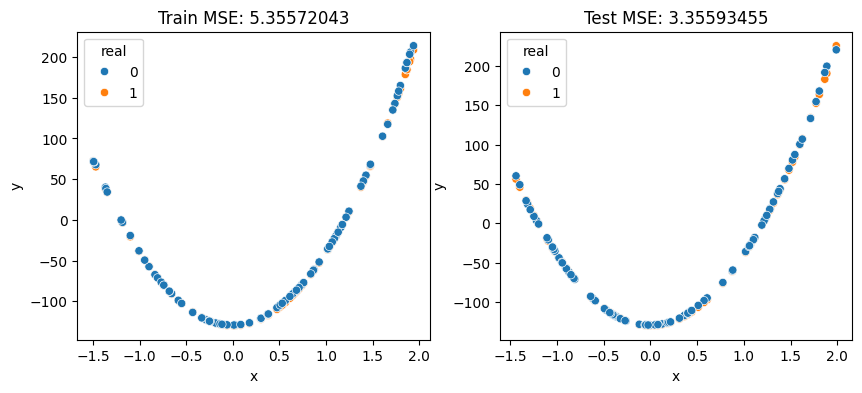

In [31]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=wykres["x"], y=wykres["y"], hue=wykres["real"])
plt.subplot(1, 2, 2)  # (rows, columns, plot_number)
sns.scatterplot(x=wykres_test["x"], y=wykres_test["y"], hue = wykres_test["real"])
plt.subplots_adjust(wspace=0.2)
plt.subplot(1, 2, 1).title.set_text(f'Train MSE: {regressor.loss_function_print(y_train, regressor.predict(X_train))}')
plt.subplot(1, 2, 2).title.set_text(f'Test MSE: {regressor.loss_function_print(y_test, regressor.predict(X_test))}')
plt.show()

In [8]:
train = pd.read_csv('/Users/adekkiezun/Downloads/dane_phishing_train.csv', index_col=0)
X_train = train.drop('CLASS_LABEL', axis=1)
y_train = train['CLASS_LABEL']
test = pd.read_csv('/Users/adekkiezun/Downloads/dane_phishing_test.csv', index_col=0)
X_test = test.drop('CLASS_LABEL', axis=1)
y_test = test['CLASS_LABEL']
train.head()
#X_train, X_test, y_train, y_test = train_test_split(dane.drop('c', axis=1), dane['c'], test_size=0.2)

,NumDots,PathLevel,UrlLength,NumDash,NumQueryComponents,NumAmpersand,NumNumericChars,DomainInPaths,HostnameLength,PathLength,QueryLength,NumSensitiveWords,PctExtHyperlinks,PctExtResourceUrls,InsecureForms,PctNullSelfRedirectHyperlinks,FrequentDomainNameMismatch,SubmitInfoToEmail,IframeOrFrame,CLASS_LABEL
1,3,5,72,0,0,0,0,0,21,44,0,0,0.000,0.250000,1,0.0,0,0,0,1
2,3,2,58,0,0,0,0,0,27,24,0,0,0.375,1.000000,1,0.0,0,0,0,1
3,3,6,79,1,0,0,0,1,22,50,0,0,1.000,0.095238,1,0.0,1,1,0,1
4,3,4,46,0,0,0,2,1,10,29,0,0,1.000,1.000000,0,0.0,1,0,1,1
5,3,1,42,1,0,0,0,1,23,12,0,0,0.100,1.000000,1,0.0,0,0,1,1


In [17]:
classifier = MLP(X=X_train, y=y_train, hidden_layer_sizes=[1], activation="sigmoid",
                  activation_output="softmax", learning_rate=0.01, epochs=100, random_w_min = -5, random_w_max = 5,
                  print_evey_n_epoch=10)#, optimizer="adam", beta1_adam=0.9, beta2_adam=0.999, epsilon=1e-8,
                  #cv_X=X_test, cv_y=y_test, batch_size=64)
classifier.fit() 

=== Epoch:    1    === Train CrossEntropy:   27713.9381   Min:   27713.9381   F1: 0.3333  ===
=== Epoch:   10    === Train CrossEntropy:   27713.0355   Min:   27713.0355   F1: 0.3333  ===
=== Epoch:   20    === Train CrossEntropy:   27712.0323   Min:   27712.0323   F1: 0.3333  ===


KeyboardInterrupt: 

In [14]:
classifier.continue_fit(50)

=== Epoch:    1    === Train CrossEntropy:   2189.2517    Min:    2041.305    F1: 0.9184  === Val CrossEntropy:    522.1326    Min:    513.621     F1:  0.921  ===
=== Epoch:   10    === Train CrossEntropy:   2090.8973    Min:    2041.305    F1: 0.9157  === Val CrossEntropy:    545.2633    Min:    513.621     F1:  0.907  ===
=== Epoch:   20    === Train CrossEntropy:   2099.0215    Min:    2041.305    F1: 0.9172  === Val CrossEntropy:    521.7159    Min:    513.3352    F1: 0.9175  ===
=== Epoch:   30    === Train CrossEntropy:   2073.1806    Min:    2041.305    F1: 0.9182  === Val CrossEntropy:    532.297     Min:    513.3352    F1:  0.912  ===
=== Epoch:   40    === Train CrossEntropy:   2070.6276    Min:    2041.305    F1:  0.921  === Val CrossEntropy:    531.3901    Min:    513.3352    F1: 0.9135  ===
=== Epoch:   50    === Train CrossEntropy:   2231.0815    Min:    2041.305    F1: 0.9094  === Val CrossEntropy:    571.963     Min:    513.3352    F1: 0.8993  ===


In [13]:
preds = classifier.predict(X_test)
preds = pd.DataFrame(preds)
preds = preds.idxmax(axis=1)
preds = pd.DataFrame(preds)
preds.columns = ["class_predicted"]
preds
f1_score(y_test, preds).round(3)

0.913

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
preds = logreg.predict(X_test)
f1_score(y_test, preds).round(3)
accuracy_score(y_test, preds).round(3)

0.913